# Machine Translation using Transformers

[Video](https://www.youtube.com/watch?v=KzfyftiH7R8&list=PLtmWHNX-gukKocXQOkQjuVxglSDYWsSh9&index=18)

In [1]:
from fastai.text import *
import pdb

In [2]:
path = Path("/ml/data/fastai/translation")  # Config().data_path()/'giga-fren'

## Data

To download the data, run the following code once:

```python
! wget https://s3.amazonaws.com/fast-ai-nlp/giga-fren.tgz -P {path}
! tar xf {path}/giga-fren.tgz -C {path} 

#with open(path/'giga-fren/giga-fren.release2.fixed.fr') as f:
#    fr = f.read().split('\n')

#with open(path/'giga-fren/giga-fren.release2.fixed.en') as f:
#    en = f.read().split('\n')

re_eq = re.compile('^(Wh[^?.!]+\?)')
re_fq = re.compile('^([^?.!]+\?)')
en_fname = path/'giga-fren/giga-fren.release2.fixed.en'
fr_fname = path/'giga-fren/giga-fren.release2.fixed.fr'

lines = ((re_eq.search(eq), re_fq.search(fq)) 
         for eq, fq in zip(open(en_fname, encoding='utf-8'), open(fr_fname, encoding='utf-8')))
qs = [(e.group(), f.group()) for e,f in lines if e and f]

qs = [(q1,q2) for q1,q2 in qs]
df = pd.DataFrame({'fr': [q[1] for q in qs], 'en': [q[0] for q in qs]}, columns = ['en', 'fr'])
df.to_csv(path/'questions_easy.csv', index=False)

del en, fr, lines, qs, df # free RAM or restart the nb
```

In [3]:
def seq2seq_collate(samples:BatchSamples, pad_idx:int=1, pad_first:bool=True, backwards:bool=False):
    "Function that collects samples and adds padding. Reverses token order if needed"
    samples = to_data(samples)
    max_len_x, max_len_y = max([len(s[0]) for s in samples]), max([len(s[1]) for s in samples])
    res_x = torch.zeros(len(samples), max_len_x).long() + pad_idx
    res_y = torch.zeros(len(samples), max_len_y).long() + pad_idx
    if backwards: pad_first = not pad_first
    
    for i, s in enumerate(samples):
        if pad_first:
            res_x[i, -len(s[0]):], res_y[i, -len(s[1]):] = LongTensor(s[0]), LongTensor(s[1])
        else:
            res_x[i, :len(s[0])], res_y[i, :len(s[1])] = LongTensor(s[0]), LongTensor(s[1])
    if backwards:
        res_x, res_y = res_x.flip(1), res_y.flip(1)
    return res_x, res_y
        

In [4]:
class Seq2SeqDataBunch(TextDataBunch):
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=32, val_bs:int=None, pad_idx=1,
               pad_first=False, device:torch.device=None, no_check:bool=False, backwards:bool=False, **dl_kwargs) -> DataBunch:
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(seq2seq_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs//2)
        
        # bugfix
        new_dl_kwargs = dl_kwargs.copy()
        new_dl_kwargs.pop('dl_tfms')
        
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **new_dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **new_dl_kwargs))
        return cls(*dataloaders, path=path, device=device, collate_fn=collate_fn, no_check=no_check)

In [5]:
class Seq2SeqTextList(TextList):
    _bunch = Seq2SeqDataBunch
    _label_cls = TextList

In [6]:
df = pd.read_csv(path/'questions_easy.csv')

In [7]:
src = Seq2SeqTextList.from_df(df, path=path, cols="fr").split_by_rand_pct().label_from_df(cols='en', label_cls=TextList)

In [8]:
src

LabelLists;

Train: LabelList (41865 items)
x: Seq2SeqTextList
xxbos xxmaj où sommes - nous ?,xxbos xxmaj d'où xxunk - nous ?,xxbos xxmaj quelle sont les coordonnées ( latitude et longitude ) de xxmaj xxunk , à xxmaj terre - xxmaj neuve - xxunk ?,xxbos xxmaj quels sont les avantages et les désavantages d’utiliser un atlas en ligne comparativement à un atlas en copie papier ?,xxbos à quel type de couverture des terres associez - vous les couleurs ci - dessous ?
y: TextList
xxbos xxmaj who are we ?,xxbos xxmaj where did we come from ?,xxbos xxmaj what is the absolute location ( latitude and longitude ) of xxmaj badger , xxmaj newfoundland and xxmaj labrador ?,xxbos xxmaj what are the advantages and disadvantages of using an online atlas versus a paper atlas ?,xxbos xxmaj what types of land cover are associated with the colours below ?
Path: /ml/data/fastai/translation;

Valid: LabelList (10466 items)
x: Seq2SeqTextList
xxbos xxmaj qui en est responsable ?,xxbos xxmaj comment puis - je as

In [9]:
np.percentile([len(o) for o in src.train.x.items] + [len(o) for o in src.valid.x.items], 90)

29.0

In [10]:
np.percentile([len(o) for o in src.train.y.items] + [len(o) for o in src.valid.y.items], 90)

26.0

**We remove any sentences that are longer than 30 tokens:**

In [11]:
src = src.filter_by_func(lambda x,y: len(x) > 30 or len(y) > 30)

In [12]:
len(src.train), len(src.valid)

(37886, 9501)

In [200]:
data = src.databunch()

In [201]:
x, y = next(iter(data.train_dl))

In [202]:
x.shape, y.shape

(torch.Size([64, 30]), torch.Size([64, 30]))

In [16]:
from IPython.display import display, HTML

def visualize_tensor(t):
    display(HTML(pd.DataFrame(np.array(t)).to_html(index=False, header=None)))

In [17]:
visualize_tensor(x)

2,5,23,22,887,10,13,397,16,984,16,260,10,122,950,38,299,37,17,3628,16,2554,3772,15,2198,4006,38,5,54,9
2,5,1917,2726,95,39,0,37,41,0,22,8039,26,0,229,13,684,18,66,13,949,10,13,4931,87,11,48,62,6511,9
2,5,32,14,5,4634,10,6067,6256,4911,55,6,4667,46,7262,11,34,11,29,14,5,4634,10,6067,6256,55,6,9106,46,9
2,5,33,189,21,81,70,5953,12,171,16,6,722,3740,17,4522,5,11016,15,17,4522,5,0,17,13,6,9026,5,0,9
2,5,27,20,99,417,205,363,563,36,12,700,26,98,5164,75,12,1319,15,13,174,16,170,15,16,582,38,5,54,9
2,5,33,22,872,1959,10,13,2080,3153,36,13,89,15,14,122,10,3264,15,66,68,11,48,62,10131,30,16,104,1720,9
2,1852,1852,5,25,20,12,167,108,10,13,5,1297,10,13,5,1387,5950,900,18,30,648,272,18,15,30,14,309,224,9
2,5,19,354,11,31,10,13,1077,10,322,2073,15,10,2302,36,12,1449,61,29,22,536,1838,10,322,36,6540,24,996,9
2,5,2476,44,584,792,2276,7681,72,5,206,24,5,54,77,18,56,28,23,156,1246,95,39,206,10,3613,24,5,54,9
2,5,393,12,137,1108,460,18,355,22,14,45,8438,312,12,541,23,1005,39,0,11,0,10,0,55,5,0,1738,46,9
2,5,32,12,803,10,800,78,12,530,60,11,49,45,2235,336,812,17,776,10,70,30,14,104,16,2339,15,16,1781,9


In [18]:
visualize_tensor(y)

2,5,25,15,209,20,2733,10,210,12,107,336,17,14,853,1299,14,5736,2736,1033,5,48,9,1,1,1,1,1,1,1
2,5,33,19,194,99,55,0,26,0,15,5559,115,5381,276,1706,18,75,35,10,2173,848,24,3764,9,1,1,1,1,1
2,5,22,15,10,5,2334,5,1068,5,194,5,4316,50,6,3721,47,4714,10,5,1068,5,194,5,4316,50,6,6700,47,9
2,5,11,15,10,59,143,20,6,654,335,2242,13,5,1776,5,7980,14,5,1776,5,0,68,6,6647,5,0,9,1,1
2,5,11,16,32,465,138,422,12,57,28,495,1156,137,14,10,242,12,156,14,586,17,5,48,9,1,1,1,1,1
2,5,11,15,10,659,87,12,904,728,28,1360,86,14,107,14,75,34,42,24,2866,17,225,985,9,1,1,1,1,1
2,5,11,16,10,155,125,12,10,6,7611,421,18,17,692,168,18,14,17,10,252,27,1852,9,1,1,1,1,1,1
2,5,11,21,23,102,45,5334,10,57,1455,14,2495,28,41,13,232,20,57,45,4566,9,1,1,1,1,1,1,1,1
2,5,11,82,24,226,19,5,84,2862,231,123,10,5,231,12,5,48,3572,9,1,1,1,1,1,1,1,1,1,1
2,5,38,12,10,173,718,218,2601,74,3513,17,551,280,0,50,5,0,1501,47,0,9,1,1,1,1,1,1,1,1
2,5,22,16,931,12,4131,13,408,74,93,13,10,599,27,852,59,12,1769,14,1069,9,1,1,1,1,1,1,1,1


In [19]:
data.show_batch()

text,target
xxbos xxmaj xxunk - on mettre sur le réseau et comment allait - on organiser l'accès à ces services pour les rendre xxunk et leur donner de la valeur ?,xxbos xxmaj what would be put on the network and how would access to those services be organized to make them attractive and give them value ?
xxbos xxmaj où se xxunk xxunk dans de l'eau douce ou de l'eau de mer « véritable » après xxunk d'un xxunk ( comme le xxunk à xxunk ) ?,"xxbos xxmaj where would the oil go in "" real "" fresh water / ocean after a xxunk ( like the xxunk xxunk ) is used ?"
xxbos xxmaj quels sont les facteurs responsables des taux plus élevés de consommation d’alcool chez les adolescentes et les jeunes femmes et de leurs niveaux plus élevés de consommation ?,xxbos xxmaj what factors are underlying increased rates of alcohol use among adolescent girls and young women as well as increased levels of consumption ?
xxbos xxmaj qui puis - je contacter à xxmaj entreprise autochtone xxmaj canada pour discuter de mon idée de projet et savoir si je suis admissible à un financement ?,xxbos xxmaj whom could i talk to at xxup abc about my project idea and whether i would be a good candidate for receiving funds ?
xxbos xxmaj quels sont les trois aspects les plus importants des changements xxunk au xxup mdn / dans les xxup fc do nt vous voudriez être mis au courant ?,xxbos xxmaj what are the three most important topics regarding change within xxup dnd / xxup cf on which you would like to be kept informed ?


## Transformer model

### Shifting
Transformation that shifts the targets right and adds a padding at the beginning.

In [20]:
def shift_tfm(b):
    x, y = b
    y = F.pad(y, (1, 0), value=1)  # prepends all sequences with a 1 in batch dimension
    return [x, y[:,:-1], y[:,1:]]

In [21]:
assert (shift_tfm((x,y))[1][:,1:] == y[:,:-1]).all()  # includes the 1s
assert (shift_tfm((x,y))[2] == y).all()  # does not include the ones

In [22]:
data.add_tfm(shift_tfm)

### Embeddings
The transformer is not reccurrent, it has no idea of the relative positions of the words. To help the transformer, we add to the input embeddings a positional encoding which is a sine of a certain frequency:

In [35]:
class PositionalEncoding(nn.Module):
    "Encode the position with a sinusoid."
    def __init__(self, d:int):
        super().__init__()
        self.register_buffer('freq', 1 / (10000 ** (torch.arange(0., d, 2.)/d)))
        
    def forward(self, pos:Tensor):
        inp = torch.ger(pos, self.freq)  # outer product
        enc = torch.cat([inp.sin(), inp.cos()], dim=-1)
        return enc

In [87]:
test_encoding = PositionalEncoding(400)  # -> gives 200 frequencies. Here you put the embedding size

In [91]:
pos = torch.arange(0, 100).float()  # -> embedding of length 100
res = test_encoding(pos)

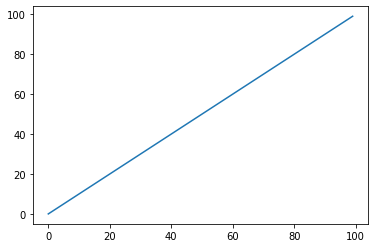

In [92]:
plt.plot(pos)

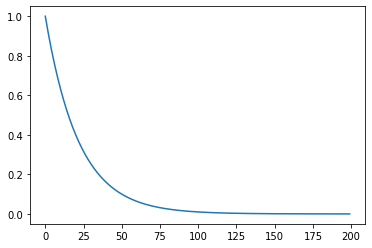

In [93]:
plt.plot(test_encoding.freq)

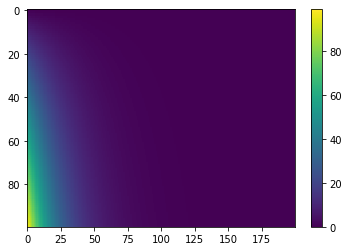

In [94]:
inp = torch.ger(pos, test_encoding.freq)
plt.imshow(inp, aspect='auto')
plt.colorbar()
plt.show()

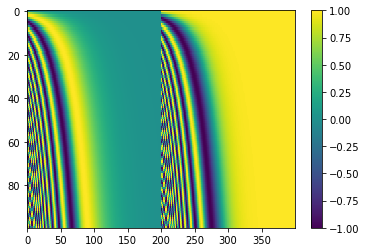

In [100]:
plt.imshow(res, aspect='auto')
plt.colorbar()
plt.show()

`res` has the shape `(100, 400)` where 100 is the length of the embedding and we have 200 sin positional embeddings followed by 200 cos positional embeddings. We only have so many frequencies for visualization purposes, later we use fewer.

In [207]:
class TransformerEmbedding(nn.Module):
    """Embedding + positional encoding + dropout"""
    def __init__(self, vocab_sz:int, emb_sz:int, inp_p:float=0.):
        super().__init__()
        self.emb_sz = emb_sz
        self.embed = embedding(vocab_sz, emb_sz)  # initializes the embedding with trunc_normal_
        self.pos_enc = PositionalEncoding(emb_sz)
        self.drop = nn.Dropout(inp_p)
        
    def forward(self, inp):
        pos = torch.arange(0, inp.size(1), device=inp.device).float()
        return self.drop(
            self.embed(inp) * math.sqrt(self.emb_sz) + self.pos_enc(pos)
        )

In [218]:
vocab_sz = len(data.train_ds.x.vocab.itos)
te= TransformerEmbedding(vocab_sz, 300).cuda()

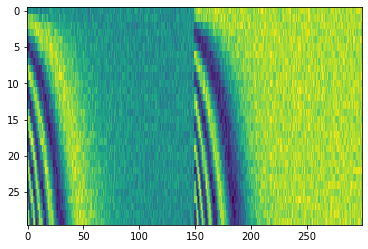

In [219]:
plt.imshow(te(x.cuda())[2], aspect='auto')